<a href="https://colab.research.google.com/github/henrikass/AI_Bootcamp/blob/master/oxford_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
   # %tensorflow_version only exists in Colab.
   %tensorflow_version 2.x
except Exception:
   pass
import tensorflow as tf

In [2]:
!pip install -q -U toai
!pip install -q -U nb_black
!pip install -q -U tensorflow-datasets
!pip install -q  --no-deps tensorflow-addons~=0.6
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

     |████████████████████████████████| 2.4MB 3.5MB/s 
     |████████████████████████████████| 1.8MB 3.5MB/s 
0.1.30
2.0.0


In [3]:
import os
from toai.imports import *
from toai.data import Dataset, DataParams, DataContainer
from toai.image import ImageLearner, ImageAugmentor, ImageDataset, ImageResizer
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/toai/imports.py:68: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


In [0]:
from typing import *


In [0]:
TEMP_DIR = Path("temp/flowers")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
BATCH_SIZE = 32
SHUFFLE_SIZE = 1024

In [0]:
IMG_DIMS = (299, 299, 3)

In [0]:
@attr.s(auto_attribs=True)
class ImageResizer:
    img_dims: Tuple[int, int, int]
    resize: Optional[str] = None
    crop_adjustment: float = 1

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        height, width, _ = self.img_dims
        if self.resize == "stretch":
            image = tf.image.resize(image, (height, width))
        elif self.resize == "crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(
                images=image, size=(crop_height, crop_width), preserve_aspect_ratio=True
            )
            image = tf.image.resize_with_crop_or_pad(image, height, width)
        elif self.resize == "random_crop":
            crop_height, crop_width = [
                int(x * self.crop_adjustment) for x in (height, width)
            ]
            image = tf.image.resize(image, (crop_height, crop_width))
            image = tf.image.random_crop(image, self.img_dims)

        return image, label

In [0]:
@attr.s(auto_attribs=True)
class ImageScaler:
    scale_fn: Callable

    def __call__(self, image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        return self.scale_fn(image), label

In [10]:
train_data, train_data_info = tfds.load(
    name="oxford_flowers102:2.*.*",
    split="train[10%:]",
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteVSYQNX/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteVSYQNX/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteVSYQNX/oxford_flowers102-validation.tfrecord



Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.0.0. Subsequent calls will reuse this data.


In [11]:
for x, y in train_data.take(1):
    print(x.shape, y.shape)

(500, 667, 3) ()


In [0]:
train_data_size = len([x for x, _ in train_data])

In [13]:
y

<tf.Tensor: id=25177, shape=(), dtype=int64, numpy=9>

In [14]:
train_data_size

918

In [0]:
train_data_steps = math.ceil(train_data_size / BATCH_SIZE)

In [16]:
train_data_steps

29

In [0]:
n_classes = 102

In [0]:
train_data = (
    train_data.map(map_func=ImageResizer(img_dims=IMG_DIMS, resize="stretch"))
    .map(map_func=ImageScaler(keras.applications.xception.preprocess_input))
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [19]:
for x, y in train_data.take(1):
    print(x.numpy().min(), x.numpy().max(), x.numpy().mean())
    print(y)

-1.0 1.0 -0.23365821
tf.Tensor(
[ 92   9  93  33   4 101  69  83  57  65  64  49  25  40  18  11  60  52
  71  77  60  40  47  28  22  89  64  83  49  97  77  86], shape=(32,), dtype=int64)


In [0]:
validation_data, validation_data_info = tfds.load(
    name="oxford_flowers102:2.*.*",
    split="train[:10%]",
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
)

In [0]:
validation_data_size = len([x for x, _ in validation_data])


In [22]:
validation_data_size

102

In [0]:
validation_data_steps = math.ceil(validation_data_size / BATCH_SIZE)

In [24]:
validation_data_steps

4

In [0]:
validation_data = (
    validation_data.map(map_func=ImageResizer(img_dims=IMG_DIMS, resize="stretch"))
    .map(map_func=ImageScaler(keras.applications.xception.preprocess_input))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [26]:
learner = ImageLearner(
    path=TEMP_DIR / "xception_v4",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[],
    override=False,
)

83689472/83683744 [==============================] - 1s 0us/step


In [27]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [0]:
learner.squeeze_layer = keras.layers.Dense(
    16,
    activation=keras.activations.relu,
    kernel_initializer=keras.initializers.he_uniform(),
)

In [0]:
learner.output_layer = keras.layers.Dense(
    n_classes, activation=keras.activations.softmax
)

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=learner.output_layer(learner.squeeze_layer(learner.dropout_layer)),
)

In [31]:
learner.model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
learner.compile(optimizer=keras.optimizers.Adam, lr=1e-4)

In [33]:
learner.model.fit(
    x=train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data_steps,
    validation_steps=validation_data_steps,
    epochs=3,
)

Train for 29 steps, validate for 4 steps
Epoch 1/3
29/29 [==============================] - 89s 3s/step - loss: 4.3567 - val_loss: 4.4880
Epoch 2/3
29/29 [==============================] - 70s 2s/step - loss: 3.4910 - val_loss: 4.2098
Epoch 3/3
29/29 [==============================] - 70s 2s/step - loss: 2.8341 - val_loss: 3.9409


In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=learner.squeeze_layer(learner.dropout_layer),
)

In [35]:
learner.model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
def show_distances(
    xs, ys, target_index, similar_indices, distances, cols: int = 4, debug: bool = False
):
    if cols >= len(distances) + 1:
        cols = len(distances) + 1
        rows = 1
    else:
        rows = math.ceil((len(distances) + 1) / cols)

    figsize = (3 * cols, 4 * rows) if debug else (3 * cols, 3 * rows)
    _, ax = plt.subplots(rows, cols, figsize=figsize)

    i = 0
    for x, y, distance in zip(
        xs[[target_index] + similar_indices],
        ys[[target_index] + similar_indices],
        [0] + distances,
    ):
        idx = (i // cols, i % cols) if rows > 1 else i % cols
        ax[idx].axis("off")
        ax[idx].imshow(x)
        title = f"Label: {y}\nShape: {x.shape}\n" if debug else f"{y}\n{distance:.2f}"
        ax[idx].set_title(title)
        i += 1

In [0]:
def dataset_to_array(dataset, steps):
    xs = []
    ys = []
    for x_batch, y_batch in dataset.take(steps):
        xs.append(x_batch.numpy())
        ys.append(y_batch.numpy())

    return np.asarray(xs).reshape((-1, *IMG_DIMS)), np.asarray(ys).flatten()

In [0]:
def inverse_preprocess_input(x):
    return (x + 1) / 2

In [0]:
learner.compile(optimizer=keras.optimizers.Adam, lr=1e-4)


In [0]:
xs, ys = dataset_to_array(validation_data, validation_data_steps)


In [41]:
xs.shape, ys.shape

((128, 299, 299, 3), (128,))

In [0]:
image_embeddings = learner.model.predict(xs)

In [43]:
image_embeddings.shape

(128, 16)

In [0]:
nbrs = sk.neighbors.NearestNeighbors(n_neighbors=19, algorithm="ball_tree").fit(
    image_embeddings
)

In [45]:
new_image_index = np.random.randint(len(ys))
new_image_index

58

In [0]:
new_prepared_image = xs[new_image_index : new_image_index + 1]

In [0]:
new_image_embeddings = learner.model.predict(new_prepared_image)

In [48]:
new_image_embeddings.shape

(1, 16)

In [0]:
distances, indices = nbrs.kneighbors(new_image_embeddings)

In [50]:
distances[0].tolist(), indices[0].tolist()

([3.265496915772499e-06,
  2.065735942521848,
  2.4619950559542785,
  2.4619950559542785,
  3.314564927582002,
  3.625187953434753,
  3.705523373306589,
  3.716016881004927,
  3.795549055355655,
  3.887367465940785,
  4.141876992251296,
  4.22039226023881,
  4.2477461525126445,
  4.330998667362151,
  4.336735443124327,
  4.34337294792965,
  4.34337294792965,
  4.4114586055245555,
  4.433422618379965],
 [58,
  31,
  127,
  25,
  80,
  32,
  98,
  68,
  36,
  35,
  44,
  28,
  82,
  67,
  95,
  11,
  113,
  60,
  91])

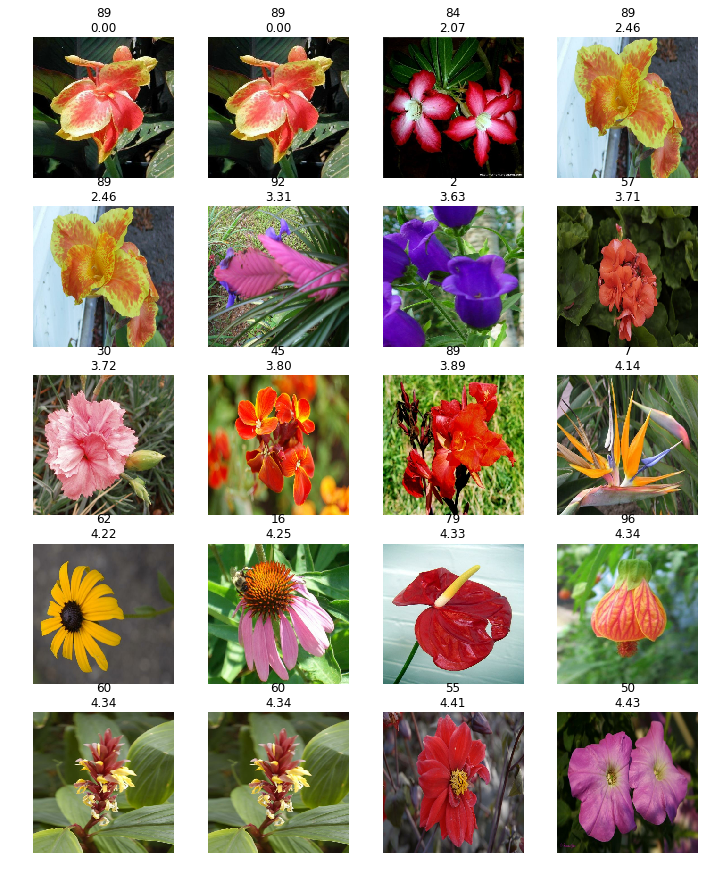

In [53]:
show_distances(
    inverse_preprocess_input(xs),
    ys,
    new_image_index,
    indices[0].tolist(),
    distances[0].tolist()
)

In [0]:
learner.loss = tfa.losses.TripletSemiHardLoss()


In [0]:
learner.stl_squeeze_layer = keras.layers.Dense(16, activation=None)


In [0]:
from funcy import compose


In [0]:
lambda_layer = keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))


In [58]:
compose(lambda_layer, learner.stl_squeeze_layer)(learner.concat_layer)


<tf.Tensor 'lambda/Identity:0' shape=(None, 16) dtype=float32>

In [0]:
learner.model = keras.Model(
    inputs=learner.base_model.input,
    outputs=lambda_layer(
        learner.stl_squeeze_layer(learner.concat_layer)
    ),
)

In [61]:
learner.model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
learner.compile(optimizer=keras.optimizers.Adam, lr=1e-4)


In [63]:
history = learner.model.fit(
    x=train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data_steps,
    validation_steps=validation_data_steps,
    epochs=3,
)

Train for 29 steps, validate for 4 steps
Epoch 1/3
29/29 [==============================] - 83s 3s/step - loss: 0.8194 - val_loss: 0.7639
Epoch 2/3
29/29 [==============================] - 71s 2s/step - loss: 0.6938 - val_loss: 0.7653
Epoch 3/3
29/29 [==============================] - 71s 2s/step - loss: 0.6997 - val_loss: 0.7870


In [0]:
image_embeddings = learner.model.predict(xs)


In [65]:
image_embeddings.shape


(128, 16)

In [0]:
nbrs = sk.neighbors.NearestNeighbors(n_neighbors=19, algorithm="ball_tree").fit(
    image_embeddings
)

In [67]:
#new_image_index = np.random.randint(len(ys))
#new_image_index

35

In [0]:
# new_image_index = 58

In [0]:
new_prepared_image = xs[new_image_index : new_image_index + 1]


In [0]:
new_image_embeddings = learner.model.predict(new_prepared_image)


In [0]:
distances, indices = nbrs.kneighbors(new_image_embeddings)


In [77]:
distances[0].tolist(), indices[0].tolist()

([8.272619228881856e-07,
  0.6732542907363078,
  0.6732542907363078,
  0.7255542436136719,
  0.7286660277284549,
  0.7588769794312966,
  0.7829511187200855,
  0.7836142795363691,
  0.8470121845645626,
  0.8592919670385762,
  0.8751622241929201,
  0.8853122898501183,
  0.910131731838289,
  0.910131731838289,
  0.9367280393872103,
  0.9373634865941416,
  0.9576883111019707,
  0.9613599603884121,
  0.9613599603884121],
 [58,
  127,
  25,
  35,
  69,
  68,
  92,
  101,
  67,
  38,
  91,
  55,
  103,
  1,
  27,
  29,
  36,
  111,
  9])

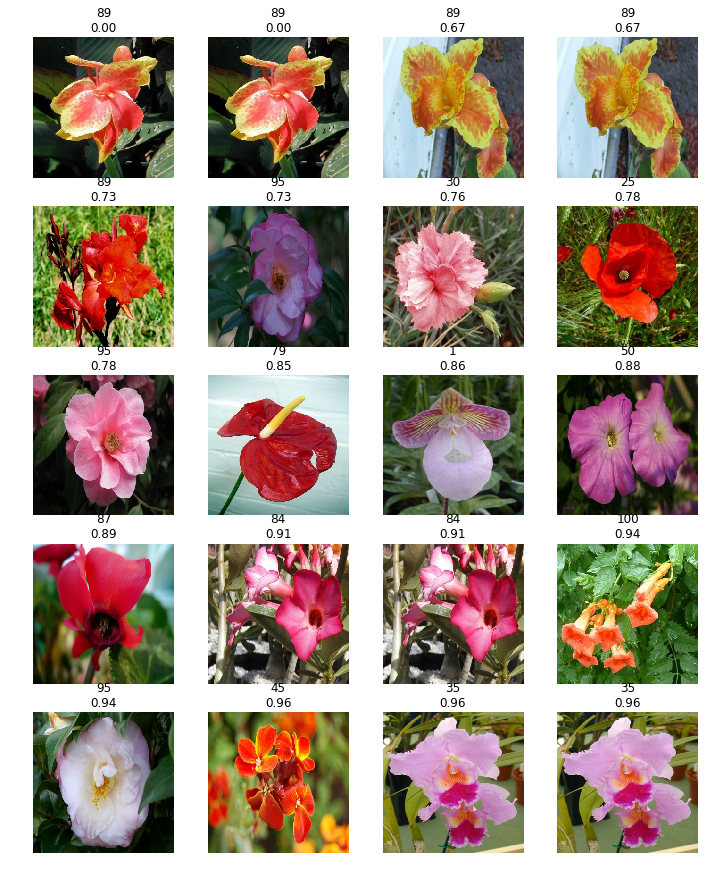

In [78]:
show_distances(
    inverse_preprocess_input(xs),
    ys,
    new_image_index,
    indices[0].tolist(),
    distances[0].tolist(),
)